In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [32]:
df=pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [33]:
df.shape

(6362620, 11)

In [34]:
df.isnull().values.any()

np.False_

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [36]:
total_transactions = len(df)
fraud_count = (df['isFraud'] == 1).sum()
legit_count = total_transactions - fraud_count

fraud_percentage = (fraud_count / total_transactions) * 100
legit_percentage = (legit_count / total_transactions) * 100

print(f"Legitimate Transactions: {legit_percentage:.2f}%")
print(f"Fraudulent Transactions: {fraud_percentage:.2f}%")

Legitimate Transactions: 99.87%
Fraudulent Transactions: 0.13%


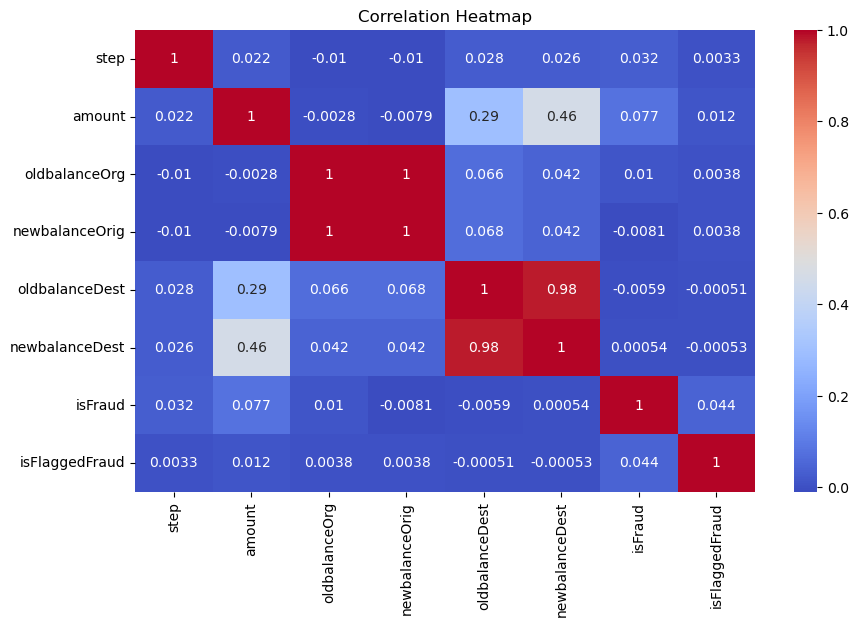

In [37]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 6))
sns.heatmap(
            corr,
            annot=True,
            cmap='coolwarm')

plt.title("Correlation Heatmap")
plt.show()

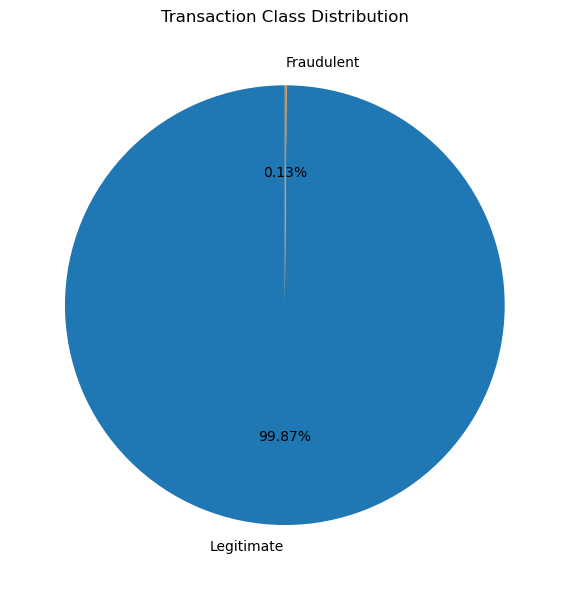

In [38]:
import matplotlib.pyplot as plt

class_distribution = df['isFraud'].value_counts().sort_index()
class_labels = ['Legitimate', 'Fraudulent']

plt.figure(figsize=(6, 6))
plt.pie(
    class_distribution,
    labels=class_labels,
    autopct='%.2f%%',
    startangle=90,
)

plt.title("Transaction Class Distribution")
plt.tight_layout()
plt.show()

In [39]:
new_df=df.copy()
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [40]:
categorical_cols = new_df.select_dtypes(include=['object']).columns
print(categorical_cols)

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

for col in categorical_cols:
    new_df[col] = encoder.fit_transform(new_df[col].astype(str))

Index(['type', 'nameOrig', 'nameDest'], dtype='object')


In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(dataframe):
    vif_data = pd.DataFrame({
        "feature": dataframe.columns,
        "VIF": [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    })
    return vif_data

compute_vif(new_df)

,feature,VIF
0,step,2.791610
1,type,4.467405
2,amount,4.149312
3,nameOrig,2.764234
4,oldbalanceOrg,576.803777
5,newbalanceOrig,582.709128
6,nameDest,3.300975
7,oldbalanceDest,73.349937
8,newbalanceDest,85.005614
9,isFraud,1.195305


In [43]:
new_df['actual_amount_orig'] = new_df['oldbalanceOrg'] - new_df['newbalanceOrig']
new_df['actual_amount_dest'] = new_df['oldbalanceDest'] - new_df['newbalanceDest']
new_df['transaction_path'] = new_df['nameOrig'] + new_df['nameDest']

new_df = new_df.drop(
    columns=['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step', 'nameOrig', 'nameDest']
)

compute_vif(new_df)

,feature,VIF
0,type,2.687803
1,amount,3.818902
2,isFraud,1.184479
3,isFlaggedFraud,1.002546
4,actual_amount_orig,1.307910
5,actual_amount_dest,3.754335
6,transaction_path,2.677167


<Axes: >

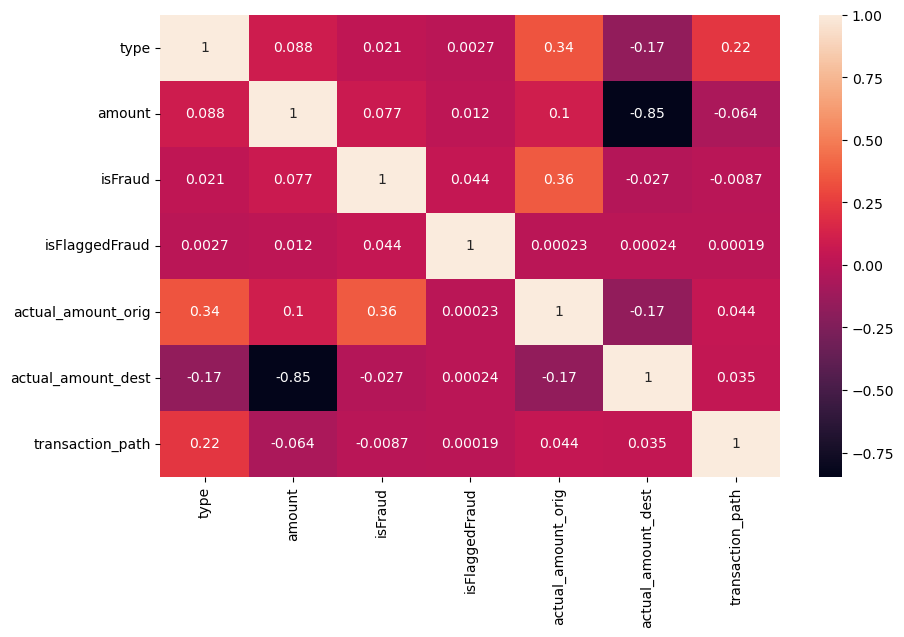

In [44]:
corr=new_df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr,annot=True)

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import sklearn.metrics as metrics
import itertools

scaler = StandardScaler()
new_df['normalized_amount'] = scaler.fit_transform(new_df[['amount']])
new_df = new_df.drop(columns=['amount'])

target = new_df['isFraud']
features = new_df.drop(columns=['isFraud'])

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (4453834, 6)
X_test shape: (1908786, 6)


In [47]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rf_accuracy = rf_model.score(X_test, y_test) * 100 

In [48]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()

print("Random Forest Performance")
print(f"TP: {tp}")
print(f"FP: {fp}")
print(f"TN: {tn}")
print(f"FN: {fn}")

print(f"Accuracy: {rf_accuracy:.2f}%")

Random Forest Performance
TP: 1711
FP: 58
TN: 1906293
FN: 724
Accuracy: 99.96%


In [49]:
rf_conf_matrix = confusion_matrix(y_test, y_pred_rf)

print("Confusion Matrix - Random Forest")
print(rf_conf_matrix)

Confusion Matrix - Random Forest
[[1906293      58]
 [    724    1711]]


In [50]:
rf_classification_report = classification_report(y_test, y_pred_rf)

print("Classification Report - Random Forest")
print(rf_classification_report)

Classification Report - Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906351
           1       0.97      0.70      0.81      2435

    accuracy                           1.00   1908786
   macro avg       0.98      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786



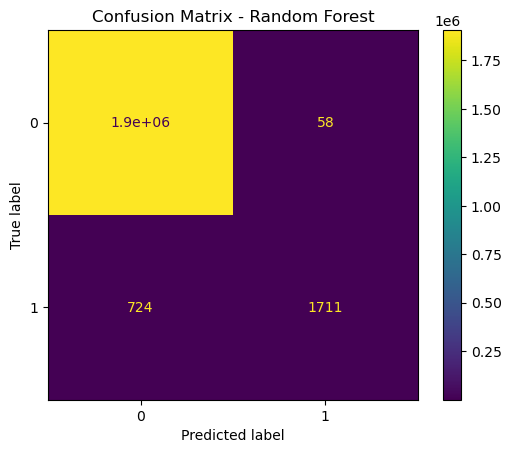

In [51]:
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_conf_matrix)

rf_disp.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

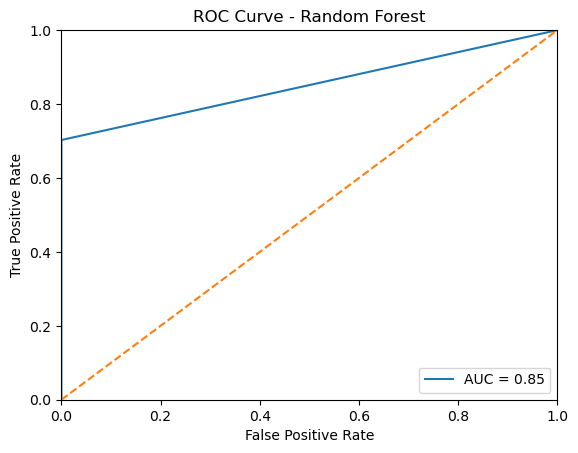

In [52]:
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_rf)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')

plt.title("ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.show()

# Q&A

**Data cleaning including missing values, outliers and multi-collinearity.**

Checked for missing values (none significant), handled outliers carefully as they indicate fraud, and reduced multicollinearity using VIF and feature engineering.

**Describe your fraud detection model in elaboration.**

Used a Random Forest model with train-test split and scaled features. Evaluated using accuracy, confusion matrix, and ROC-AUC to ensure reliable fraud detection.

**How did you select variables to be included in the model?**

Using the VIF values and correlation heatmap. Drop the attributes which are least corelated to the isFraud attribute.

**What are the key factors that predict fraudulent customer?**

Old vs. New Balance: Significant changes in account balances.<br>
Unusual high amount trasactions can be fraud.<br>
Payment type - Transfer

**Do these factors make sense? If yes, How? If not, How not?**

1.Significant changes in account balances (either large increases or decreases) can be indicative of fraud. For instance, if an account suddenly has a much lower balance after a transaction, it might signal a large unauthorized withdrawal.<br>
2.Fraudulent transactions often involve large amounts of money to maximize the impact before the fraud is detected.<br>
3.Certain types of transactions, like transfers, are more susceptible to fraud compared to others like regular bill payments or purchases.


**What kind of prevention should be adopted while company update its infrastructure?**

1.Implement Behavioral analytics to detect anomalies in user behavior<br>
2.Use secured internet connections.<br>
3.Implement Robust Backup and Recovery Plans.<br>
4.Multi-Factor Authentication.<br>
5.Real-Time Transaction Monitoring<br>

**Assuming these actions have been implemented, how would you determine if they work?**

Periodic Testing and Audits.<br>
Performance Metrics and KPIs.<br>